### Test augmentation for YOLO v5-v8

In this Notebook I'm testing how to create augmentated images (for example: with rotation) generating the new image and all 
the rotated BB rectangles.

I'm going to use Albumentations, see: https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/

In [1]:
from os import path
import glob
import cv2
import albumentations as A
import matplotlib.pyplot as plt

%matplotlib inline

#### Supporting functions for working with BB and YOLO BB

In [2]:
from common_functions import (read_bb, write_bb, yolo_to_cv2, do_check, 
                              show_image_and_bbs)

In [5]:
DATASET_BASE_DIR = "/Users/lsaetta/Progetti/yolo_augmentations/yolo_dataset/train"
# under this dir I have images and labels

images_list = sorted(glob.glob(path.join(DATASET_BASE_DIR, "images/*.jpg")))
labels_list = sorted(glob.glob(path.join(DATASET_BASE_DIR, "labels/*.txt")))

INDEX = 2

image_path = images_list[INDEX]
label_path = labels_list[INDEX]

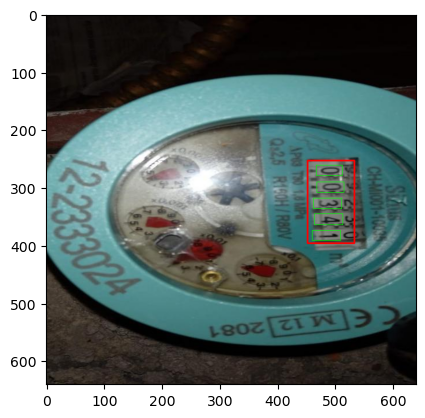

In [6]:
# Visualize image with BB

img = cv2.imread(image_path)

# consider that cv2 is using BGR we need to convert for matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# read bb
yolo_bb_list = read_bb(label_path)

show_image_and_bbs(img_rgb, yolo_bb_list)

#### define an Albumentations Transform

see: https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/

In [7]:
# do NOT set a random seed before executing transform

# for now removed horizontal flip, risk to change digits
# A.HorizontalFlip(p=0.5),
transform = A.Compose(
    [A.Rotate(limit=90), 
    A.RandomSizedBBoxSafeCrop(width=640, height=640, erosion_rate=0.2),
    A.PixelDropout()],
    bbox_params=A.BboxParams(format="yolo"),
)

####  Apply transform and show the results with the transformed BB

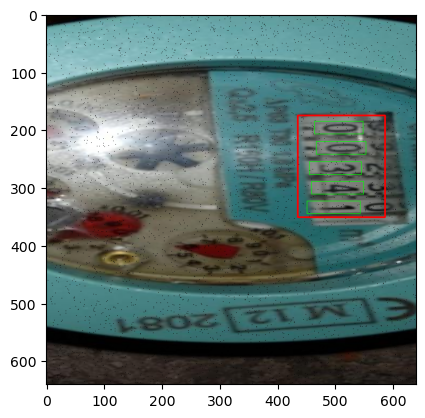

In [8]:
# all bb transforms
# every time we re-execute this cell we will get a different rotated image
# but with correctly trasformed bb (check also the green bb)

transformed = transform(image=img_rgb, bboxes=yolo_bb_list)
transformed_image = transformed["image"]
transformed_bboxes = transformed["bboxes"]

# we take here only the global bb, that is the last one
# check that it is really the last one
assert transformed_bboxes[-1][4] == 10

# a single call, nice!
show_image_and_bbs(transformed_image, transformed_bboxes)

#### Finally, We can do some formal checks

In [9]:
do_check(yolo_bb_list, transformed_bboxes)

print("All check have been correctly verified !")

All check have been correctly verified !


#### Write the new labels

In [10]:
# write the new image
# before writing back to bgr
img_bgr = cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB)
cv2.imwrite("./test1.jpg", img_bgr)

# write new labels
write_bb("./test1.txt", transformed_bboxes)

#### now check that image and BB are matching

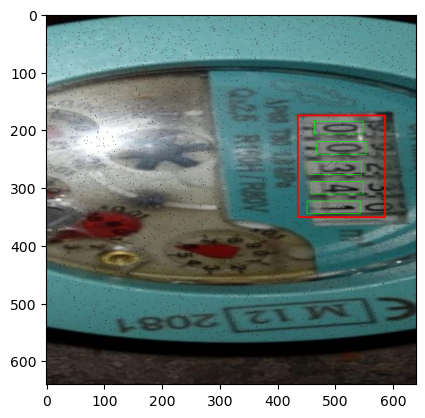

In [11]:
img = cv2.imread("./test1.jpg")

# consider that cv2 is using BGR we need to convert for matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# read bb
yolo_bb_list = read_bb("./test1.txt")

show_image_and_bbs(img_rgb, yolo_bb_list)